# PCA using Sentinel-2

Authors:

* Jeroen Wannijn

## Introduction

In this notebook we will be performing a principal component analysis using a full data cube of preprocessed Sentinel data (for the WEED-project) created retrieved from- and processed on openEO.

In [18]:
from pathlib import Path
import openeo
from openeo import processes as eop
import matplotlib.pyplot as plt
import xarray as xr
from eo_processing.openeo.processing import generate_master_feature_cube

# openeo version
openeo.client_version()

'0.40.0'

In [19]:
## creates a output directory if it doesn't exist.
base_path = Path("results")
if not base_path.is_dir():
    base_path.mkdir()

## Authentication

We first need to connect to an openEO provider. Most providers require you to register an account, and provide you with a basic amount of processing credits. 
In this notebook we will use the Copernicus Data Scpace Ecosystem as openEO provider.

All the known openEO providers and their services:
https://hub.openeo.org/ 

More info on authentication:
https://open-eo.github.io/openeo-python-client/auth.html

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [20]:
backend_url = "openeo.dataspace.copernicus.eu/"

eoconn = openeo.connect(backend_url)
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A. More information on the collections available can be displayed with `eoconn.list_collections()`.
Use `eoconn.describe_collection("SENTINEL2_L2A")` for example to get the description of a specific collection.

More information on finding and loading data: 
https://open-eo.github.io/openeo-python-client/data_access.html

In [21]:
BBOX = {"east": 4880000, "south": 2896000, "west": 4876000, "north": 2900000, 'crs': 'EPSG:3035'} # 4x4km bbox in Germany
DATE_START = "2021-01-01"
DATE_END = "2021-03-01"

### Select usable observations

Select bands with usable observations to compute ndvi by applying a strict cloud cover. Select data where the cloud cover is less than 10%.


In [22]:
sentinel_master_cube = generate_master_feature_cube(
        connection=eoconn,
        S1_collection='SENTINEL1_GRD',
        S2_collection='SENTINEL2_L2A',
        bbox=BBOX,
        start=DATE_START,
        end=DATE_END)


In [25]:
import openeo
import numpy as np
import matplotlib.pyplot as plt

rgb_cube = eoconn.load_collection(
    "SENTINEL2_L2A",  # or your collection id
    spatial_extent=BBOX,
    temporal_extent="2021",
    bands=['B02', 'B03', 'B04']
)

# Reduce to a single time slice, e.g. take median over time to get 2D image
rgb_cube = rgb_cube.reduce_dimension(dimension='t', reducer='mean')

rgb_cube.download(base_path / "rgb_cube.tiff")

Pixel Size: 10.0 x 10.0 units


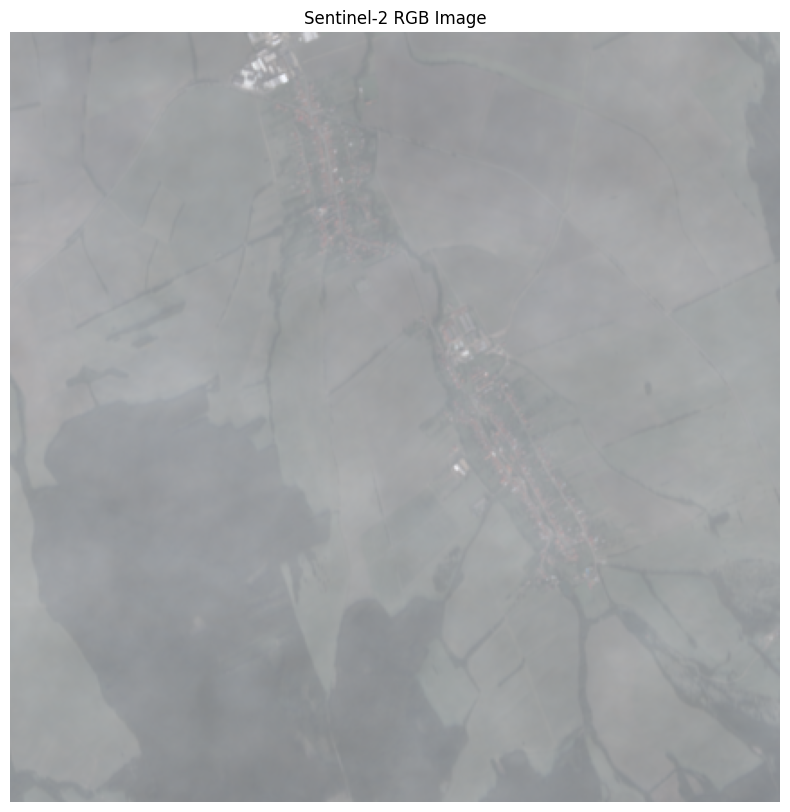

In [55]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open(base_path / "rgb_cube.tiff") as src:
    # Print pixel size
    pixel_size_x = src.transform.a  # pixel width
    pixel_size_y = -src.transform.e  # pixel height (negative because of coordinate system)
    print(f"Pixel Size: {pixel_size_x} x {pixel_size_y} units")

    # Read the bands by their Sentinel-2 band numbers
    r = src.read(3)  # Band 4 - Red
    g = src.read(2)  # Band 3 - Green
    b = src.read(1)  # Band 2 - Blue

rgb = np.stack([r, g, b], axis=0)
rgb_img = np.transpose(rgb, (1, 2, 0))

# Normalize image for display (scale 0-1)
rgb_norm = rgb_img / np.max(rgb_img)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_norm)
plt.title("Sentinel-2 RGB Image")
plt.axis("off")
plt.show()

## Calculate PCA


In [32]:
job_options = {
    "driver-memory": "4G",
    "driver-memoryOverhead": "4G",
    "driver-cores": "1",
    "executor-memory": "2000m",
    "executor-memoryOverhead": "256m",
    "python-memory": "4G",
    "executor-cores": "1",
    "max-executors": "20",
    "logging-threshold": "info"
 }

In [ ]:
## Apply the PCA UDF using `apply_neighborhood`
pca_udf_obj = openeo.UDF.from_file("udf_pca.py", runtime="Python", context={"n_components": 4})
PCA_components = sentinel_master_cube.apply_neighborhood(
    process=pca_udf_obj,
    size=[
        {"dimension": "x", "value": 1920, "unit": "px"},
        {"dimension": "y", "value": 1920, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
    ],
)
PCA_job = PCA_components.create_job(
    title="PCA_job", out_format="NetCDF", job_options=job_options
)
PCA_job.start_and_wait()

In [ ]:
PCA_job.download_result("results/components_PCA.nc")

WindowsPath('results/PCA_components.nc')

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Load dataset
PCA_data = xr.open_dataset(base_path / "components_PCA.nc")
print(PCA_data)

<xarray.Dataset> Size: 3MB
Dimensions:  (x: 428, y: 428)
Coordinates:
  * x        (x) float64 3kB 6.894e+05 6.894e+05 ... 6.937e+05 6.937e+05
  * y        (y) float64 3kB 5.426e+06 5.426e+06 ... 5.421e+06 5.421e+06
Data variables:
    crs      |S1 1B ...
    PC1      (y, x) float32 733kB ...
    PC2      (y, x) float32 733kB ...
    PC3      (y, x) float32 733kB ...
    PC4      (y, x) float32 733kB ...
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.66.0a3.dev20...
    description:  
    title:        


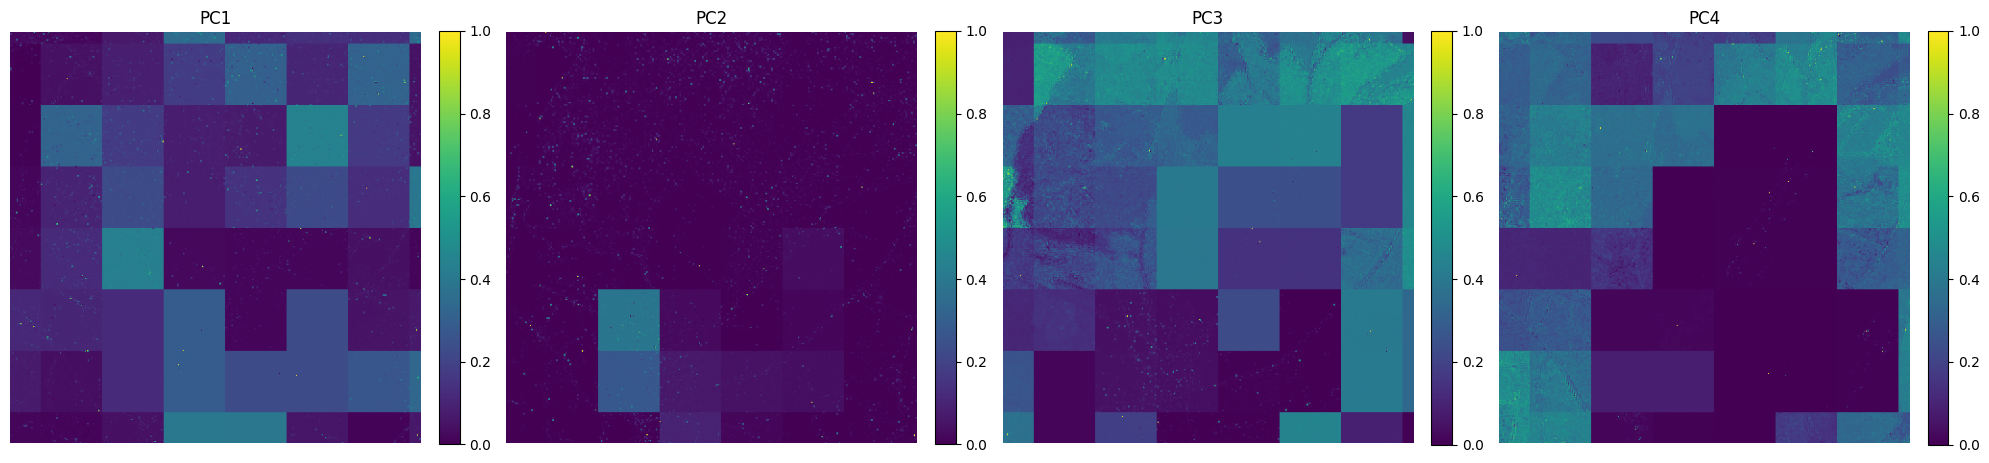

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

variables = ['PC1', 'PC2', 'PC3', 'PC4']

vmin, vmax = 0, 1  # fixed color scale limits

for ax, var in zip(axes, variables):
    im = ax.imshow(PCA_data[var], origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(var)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

#TODO train model over complete image size